In [1]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

# <p style="text-align: center;"> MALAP TP4 - Perceptron, SVMs </p>
#### <p style="text-align: center;"> Clément RIU et Anne SPITZ </p>
#### <p style="text-align: center;"> 13/04/2017 </p>

Fichier tools.py :

In [2]:
def plot_data(data, labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols, marks = ["red", "blue", "green", "orange", "black", "cyan"], [".", "+", "*", "o", "x", "^"]
    if labels is None:
        plt.scatter(data[:, 0], data[:, 1], marker="x")
        return
    for i, l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels == l, 0], data[labels == l, 1], c=cols[i], marker=marks[i])

        
def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),256)


def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:, 0]), np.min(data[:, 0]), np.max(data[:, 1]), np.min(data[:, 1])
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step), np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    grid = np.c_[x.ravel(), y.ravel()]
    return grid, x, y


def gen_arti(centerx=1, centery=1, sigma=0.1, nbex=1000, data_type=0, epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type == 0:
        # melange de 2 gaussiennes
        xpos = np.random.multivariate_normal([centerx, centerx], np.diag([sigma, sigma]), int(nbex // 2))
        xneg = np.random.multivariate_normal([-centerx, -centerx], np.diag([sigma, sigma]), int(nbex // 2))
        data = np.vstack((xpos, xneg))
        y = np.hstack((np.ones(nbex // 2), -np.ones(nbex // 2)))
    if data_type == 1:
        # melange de 4 gaussiennes
        xpos = np.vstack((np.random.multivariate_normal([centerx, centerx], np.diag([sigma, sigma]), int(nbex // 4)),
                          np.random.multivariate_normal([-centerx, -centerx], np.diag([sigma, sigma]), int(nbex / 4))))
        xneg = np.vstack((np.random.multivariate_normal([-centerx, centerx], np.diag([sigma, sigma]), int(nbex // 4)),
                          np.random.multivariate_normal([centerx, -centerx], np.diag([sigma, sigma]), int(nbex / 4))))
        data = np.vstack((xpos, xneg))
        y = np.hstack((np.ones(nbex // 2), -np.ones(int(nbex // 2))))

    if data_type == 2:
        # echiquier
        data = np.reshape(np.random.uniform(-4, 4, 2 * nbex), (nbex, 2))
        y = np.ceil(data[:, 0]) + np.ceil(data[:, 1])
        y = 2 * (y % 2) - 1
    # un peu de bruit
    data[:, 0] += np.random.normal(0, epsilon, nbex)
    data[:, 1] += np.random.normal(0, epsilon, nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data = data[idx, :]
    y = y[idx]
    return data, y


Fichier tp4-etu.py :

In [44]:
class Perceptron:
    def __init__(self, max_iter=100, eps=1e-3, projection=None, grad_alg=None):
        self.max_iter = max_iter
        self.eps = eps
        self.grad_alg = grad_alg or self.grad_descent
        self.projection = projection or (lambda x: x)  # projection fonction identite par default

    def fit(self, data, y):
        data = self.projection(data)
        self.w = np.random.random((1, data.shape[1]))
        self.histo_w = np.zeros((self.max_iter, data.shape[1]))
        self.histo_f = np.zeros((self.max_iter, 1))
        ylab = set(y.flat)
        if len(ylab) != 2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1: max(ylab)}
        y = 2 * (y != self.labels[-1]) - 1
        i = 0

        self.grad_alg(data, y)
        
    def predict(self, data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))

    def score(self, data, y):
        return np.mean(self.predict(data) == y)

    def get_eps(self):
        return self.eps

    def loss(self, data, y):
        return hinge(self.w, data, y)

    def grad_descent(self, data, y):
        i = 0
        while i < self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps() * self.loss_g(data[j], y[j:(j + 1)])
            self.histo_w[i] = self.w
            self.histo_f[i] = self.loss(data, y)
            if i % 20 == 0: print(i, self.histo_f[i])
            i += 1
    
    def loss_g(self, data, y):
        return grad_hinge(self.w, data, y)

Fichier tp3-etu.py :

In [5]:
def load_usps(filename):
    with open(filename, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)


def get_usps(l, datax, datay):
    """ l : liste des chiffres a extraire"""
    if type(l) != list:
        resx = datax[datay == l, :]
        resy = datay[datay == l]
        return resx, resy
    tmp = list(zip(*[get_usps(i, datax, datay) for i in l]))
    tmpx, tmpy = np.vstack(tmp[0]), np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx, :], tmpy[idx]


def show_usps(data):
    plt.imshow(data.reshape((16, 16)), interpolation="nearest", cmap="gray")


## <p style="text-align: center;"> 1 Implémentation du perceptron </p>

### Question 1.1 :

In [6]:
def hinge(w, data, y):
    """"""
    data, y, w = data.reshape(len(y), -1), y.reshape(-1, 1), w.reshape(1, -1)
    return np.mean(np.maximum(0, -np.multiply(y, np.dot(data, w.T))))
    
def grad_hinge(w, data, y):
    """"""
    data, y, w = data.reshape(len(y), -1), y.reshape(-1, 1), w.reshape(1, -1)
    
    value = - np.multiply(y, data)    
    sign = np.multiply(y, np.dot(data, w.T)) < 0
    
    return np.mean(np.multiply(sign, value), axis = 0)


In [25]:
### Test des fonctions hinge et grad_hinge
w = np.random.random((3,))
data = np.random.random((100, 3))
y = np.random.randint(0, 2, size=(100, 1)) * 2 - 1

print(hinge(w, data, y), hinge(w, data[0], y[0]), hinge(w, data[0, :], y[0]))
print(grad_hinge(w, data, y), grad_hinge(w, data[0], y[0]).shape, grad_hinge(w, data[0, :], y[0]).shape)

0.269704169604 0.0 0.0
[ 0.21478476  0.20656073  0.24241889] (3,) (3,)


### Question 1.2 :

In [43]:
### Generation de donnees
xtrain, ytrain = gen_arti(data_type=0, epsilon=0.5)
xtest, ytest = gen_arti(data_type=0, epsilon=0.5)

### Apprentissage
model = Perceptron(max_iter=100, eps=1e-2)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

0 [ 0.00137323]
20 [ 0.00026411]
40 [ 0.00023677]
60 [ 0.00020943]
80 [ 0.00018209]
score en train :  0.995
score en test :  0.997


Le score de la classification est bon, l'algorithme de descente de gradient a convergé.

### Question 1.3 :

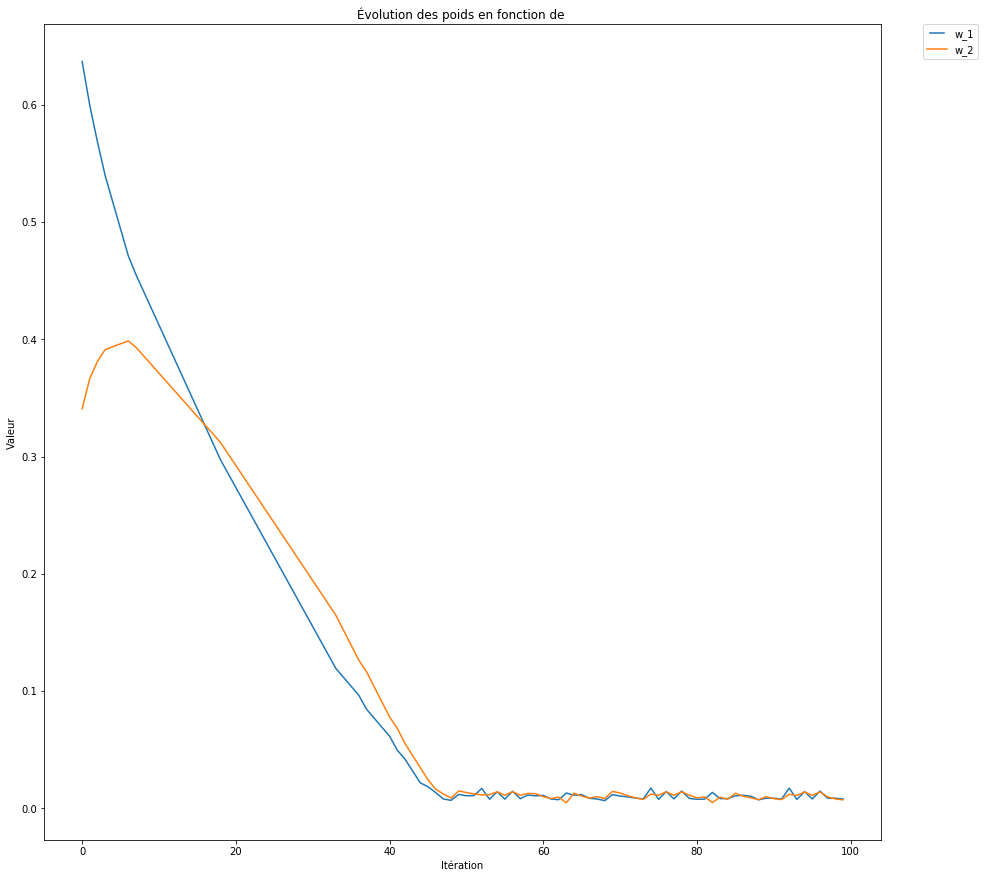

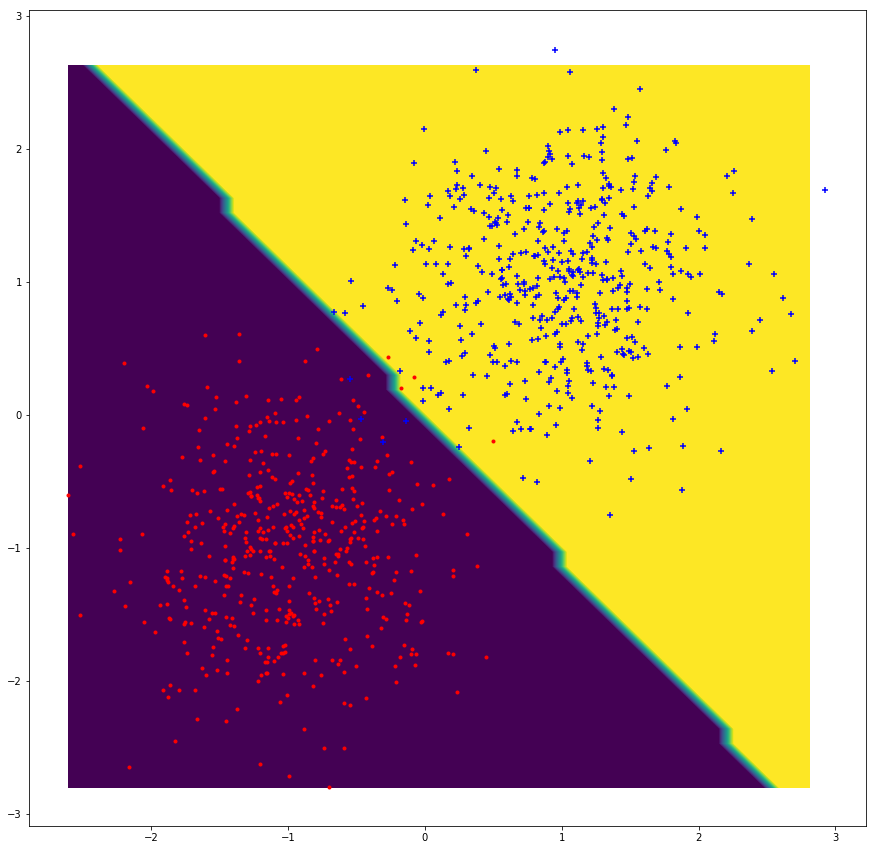

In [9]:
#### Visualisation des poids
w_tab = model.histo_w
line = []
plt.figure(num=None, figsize=(15, 15))
plt.title("Évolution des poids en fonction de ")
line.append(plt.plot(w_tab[:,0], label="w_1"))
line.append(plt.plot(w_tab[:,1], label="w_2"))
plt.xlabel("Itération")
plt.ylabel("Valeur")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handler_map={line[0][0]: HandlerLine2D(numpoints=4)})
plt.show()


#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

La solution n'est pas unique, le résultat de la minimisation de la fonction dépend des paramètres initiaux et de l'ordre dans lequel les points sont parcourus.

Dans ce cas la frontière est pertinente, elle sépare bien les données.

0 [ 0.17803978]
20 [ 0.06988011]
40 [ 0.18277459]
60 [ 0.16758944]
80 [ 0.16844767]
score en train :  0.581
score en test :  0.552


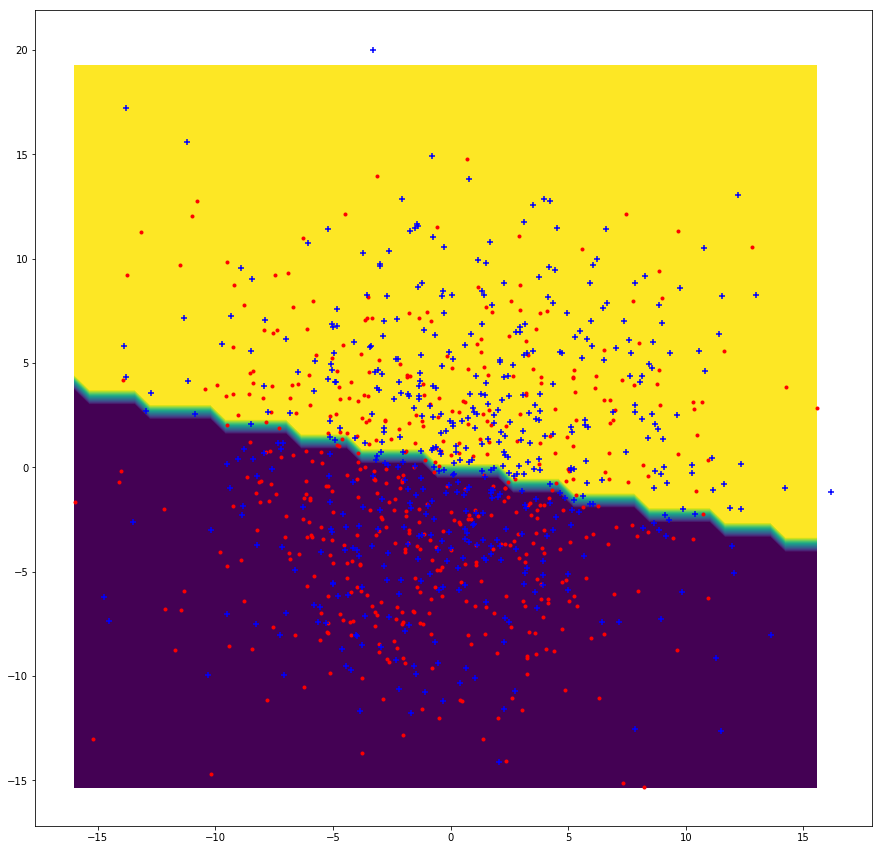

In [10]:
### Generation de donnees
xtrain, ytrain = gen_arti(data_type=0, epsilon=5.5)
xtest, ytest = gen_arti(data_type=0, epsilon=5.5)

### Apprentissage
model = Perceptron(max_iter=100, eps=1e-2)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

Lorsque le modèle est trop bruité, ce modèle n'arrive pas à séparer, le résultat correspond presque à un prédicteur constant.

### Question 1.4

In [62]:
class Perceptron:
    def __init__(self, max_iter=100, eps=1e-3, projection=None, grad_alg="grad_descent"):
        fonc_dic = {"grad_descent":self.grad_descent, "batch": self.batch, "stochastic": self.stochastic, "mini_batch": self.mini_batch}
        
        self.max_iter = max_iter
        self.eps = eps
        
        self.grad_alg = fonc_dic[grad_alg]
        self.projection = projection or (lambda x: x)  # projection fonction identite par default

    def fit(self, data, y):
        data = self.projection(data)
        self.w = np.random.random((1, data.shape[1]))
        self.histo_w = np.zeros((self.max_iter, data.shape[1]))
        self.histo_f = np.zeros((self.max_iter, 1))
        ylab = set(y.flat)
        if len(ylab) != 2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1: max(ylab)}
        y = 2 * (y != self.labels[-1]) - 1
        i = 0

        self.grad_alg(data, y)
        
    def predict(self, data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))

    def score(self, data, y):
        return np.mean(self.predict(data) == y)

    def get_eps(self):
        return self.eps

    def loss(self, data, y):
        return hinge(self.w, data, y)

    def grad_descent(self, data, y):
        i = 0
        while i < self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps() * self.loss_g(data[j], y[j:(j + 1)])
            self.histo_w[i] = self.w
            self.histo_f[i] = self.loss(data, y)
            if i % 20 == 0: print(i, self.histo_f[i])
            i += 1
            
    def batch(self, data, y):
        print("bonjour")
        
    def stochastic(self, data, y):
        i = 0
        while i < self.max_iter:
            idx = np.arange(len(data))
            np.random.shuffle(idx)
            for j in idx:
                self.w = self.w - self.get_eps() * self.loss_g(data[j], y[j:(j + 1)])
            self.histo_w[i] = self.w
            self.histo_f[i] = self.loss(data, y)
            if i % 20 == 0: print(i, self.histo_f[i])
            i += 1
        
    def mini_batch(self, data, y):
        print("bonjour")
    
    def loss_g(self, data, y):
        return grad_hinge(self.w, data, y)

In [63]:
### Generation de donnees
xtrain, ytrain = gen_arti(data_type=0, epsilon=0.5)
xtest, ytest = gen_arti(data_type=0, epsilon=0.5)

### Apprentissage
model = Perceptron(max_iter=100, eps=1e-2, grad_alg="stochastic")
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

0 [ 0.00339914]
20 [ 0.00090421]
40 [ 0.00048673]
60 [  7.36655185e-05]
80 [  1.25081205e-05]
score en train :  0.986
score en test :  0.993


## <p style="text-align: center;"> 2 Données USPS </p>

### Question 2.1 :

0 [ 1.5149788]
20 [ 0.08999995]
40 [ 0.08641822]
60 [ 0.07984758]
80 [ 0.07962653]
score en train :  0.966689326988
score en test :  0.918546365915


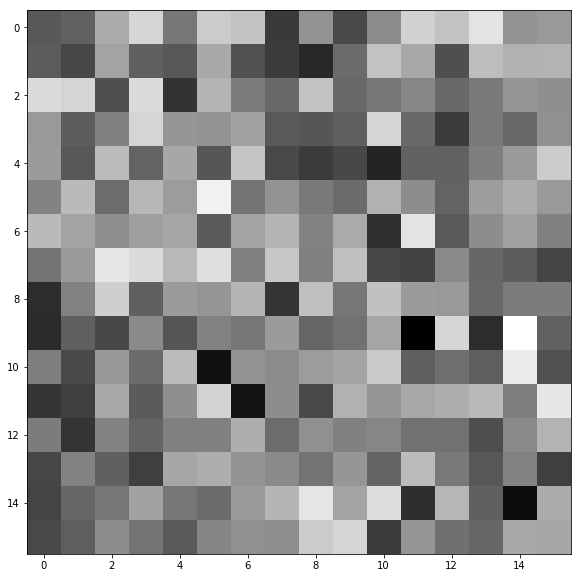

In [11]:
# Observation de données réelles :
xuspstrain, yuspstrain = load_usps("USPS_train.txt")
xuspstest, yuspstest = load_usps("USPS_test.txt")
x16train, y16train = get_usps([1, 6], xuspstrain, yuspstrain)
x28train, y28train = get_usps([2, 8], xuspstrain, yuspstrain)
x16test, y16test = get_usps([1, 6], xuspstest, yuspstest)
x28test, y28test = get_usps([2, 8], xuspstest, yuspstest)
x1268train = np.concatenate((x16train, x28train))
x1268test = np.concatenate((x16test, x28test))
y1268train = np.concatenate((y16train, y28train))
y1268test = np.concatenate((y16test, y28test))
y1268train[y1268train == 2] = 1
y1268train[y1268train == 8] = 6
y1268test[y1268test == 2] = 1
y1268test[y1268test == 8] = 6

x_chiffre_train = x1268train
x_chiffre_test = x1268test
y_chiffre_train = y1268train
y_chiffre_test = y1268test

### Apprentissage
model = Perceptron(eps=1e-2)
model.fit(x_chiffre_train, y_chiffre_train)
print("score en train : ", model.score(x_chiffre_train, y_chiffre_train))
print("score en test : ", model.score(x_chiffre_test, y_chiffre_test))

plt.figure(num=None, figsize=(20, 10))
show_usps(np.reshape(model.w, (16, 16)))
plt.show()

Le score est relativement élevé, le perceptron arrive bien à séparer les deux chiffres.

### Question 2.2 :

0 [ 1.10512971]
0 [ 1.03220402]
20 [ 0.13799915]
40 [ 0.07683707]
0 [ 0.97031339]
20 [ 0.07291588]
40 [ 0.05583001]
60 [ 0.0638141]
80 [ 0.03128062]
0 [ 0.9804096]
20 [ 0.09594399]
40 [ 0.11902905]
60 [ 0.06738861]
80 [ 0.03667643]
100 [ 0.0484366]
120 [ 0.02508678]
0 [ 0.90626076]
20 [ 0.0832432]
40 [ 0.05771567]
60 [ 0.0980907]
80 [ 0.05436992]
100 [ 0.03510523]
120 [ 0.04546545]
140 [ 0.02140924]
160 [ 0.02893537]
0 [ 0.9559434]
20 [ 0.0689532]
40 [ 0.09689101]
60 [ 0.06262488]
80 [ 0.05685016]
100 [ 0.05313717]
120 [ 0.03390345]
140 [ 0.02307834]
160 [ 0.03079514]
180 [ 0.01423425]
200 [ 0.03776242]


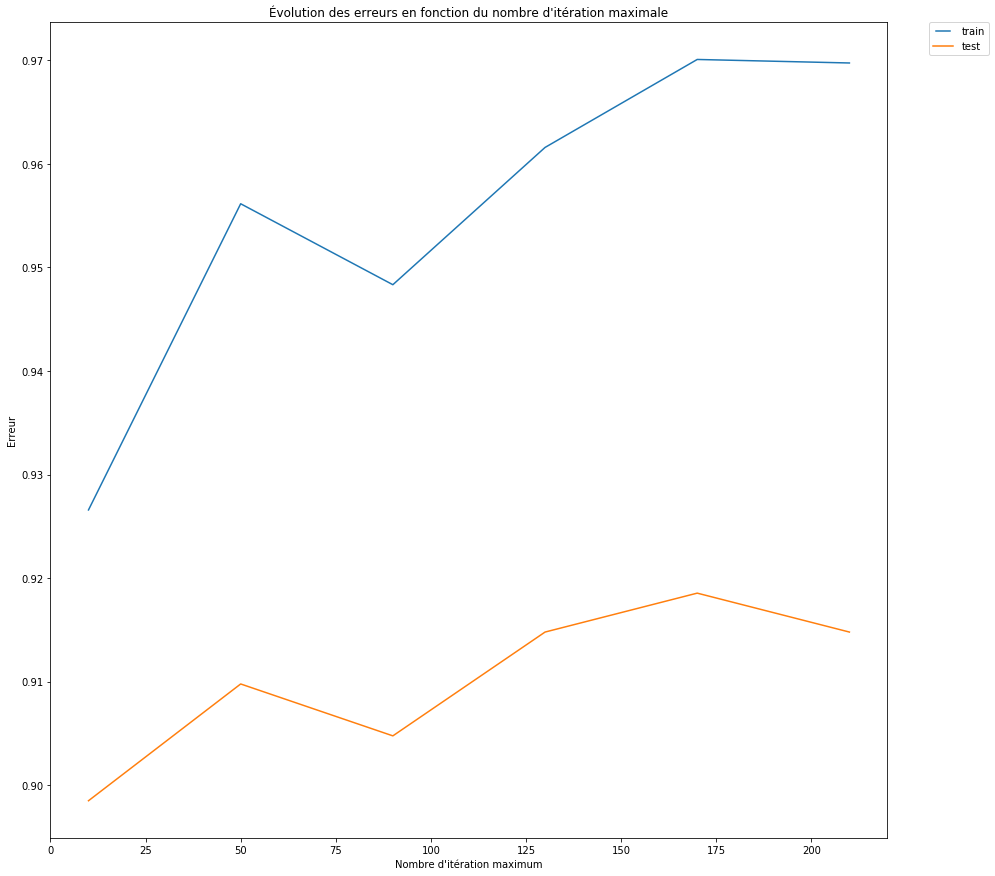

In [12]:
err_train = []
err_test = []
iter_range = range(10, 211, 40)

for max_iter in iter_range:
    ### Apprentissage
    model = Perceptron(max_iter=max_iter, eps=1e-2)
    model.fit(x_chiffre_train, y_chiffre_train)
    err_train.append(model.score(x_chiffre_train, y_chiffre_train))
    err_test.append(model.score(x_chiffre_test, y_chiffre_test))


line = []
plt.figure(num=None, figsize=(15, 15))
plt.title("Évolution des erreurs en fonction du nombre d'itération maximale")
line.append(plt.plot(iter_range, err_train, label="train"))
line.append(plt.plot(iter_range, err_test, label="test"))
plt.xlabel("Nombre d'itération maximum")
plt.ylabel("Erreur")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handler_map={line[0][0]: HandlerLine2D(numpoints=4)})
plt.show()

On observe du sur-apprentissage. En effet, l'erreur sur l'ensemble d'apprentissage croit plus vite que l'erreur sur l'ensemble de test qui presque stagne à partir de 50 itérations au maximum.

# Faire les différents settings ?

## <p style="text-align: center;"> 3 Expréssivité et feature map </p>

### Question 3.1 :

0 [ 0.00377792]
20 [ 0.00160113]
40 [ 0.00154317]
60 [ 0.00547218]
80 [ 0.00151426]
score en train :  0.512
score en test :  0.491


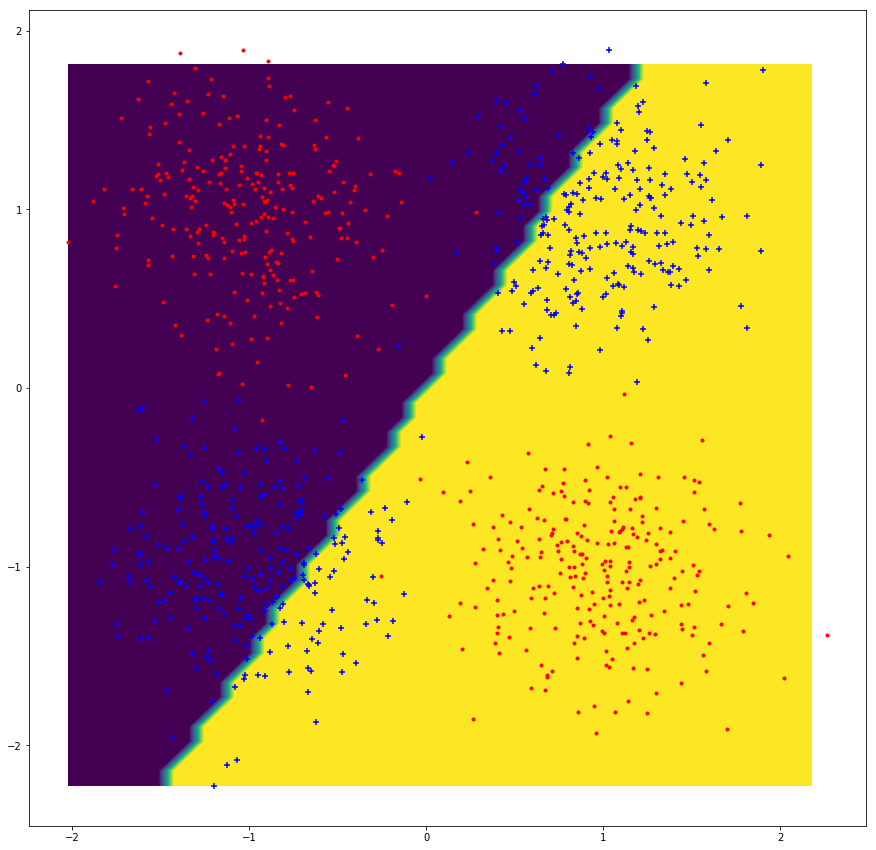

0 [ 0.04059247]
20 [ 0.0204163]
40 [ 0.02513702]
60 [ 0.03536329]
80 [ 0.03239674]
score en train :  0.477
score en test :  0.48


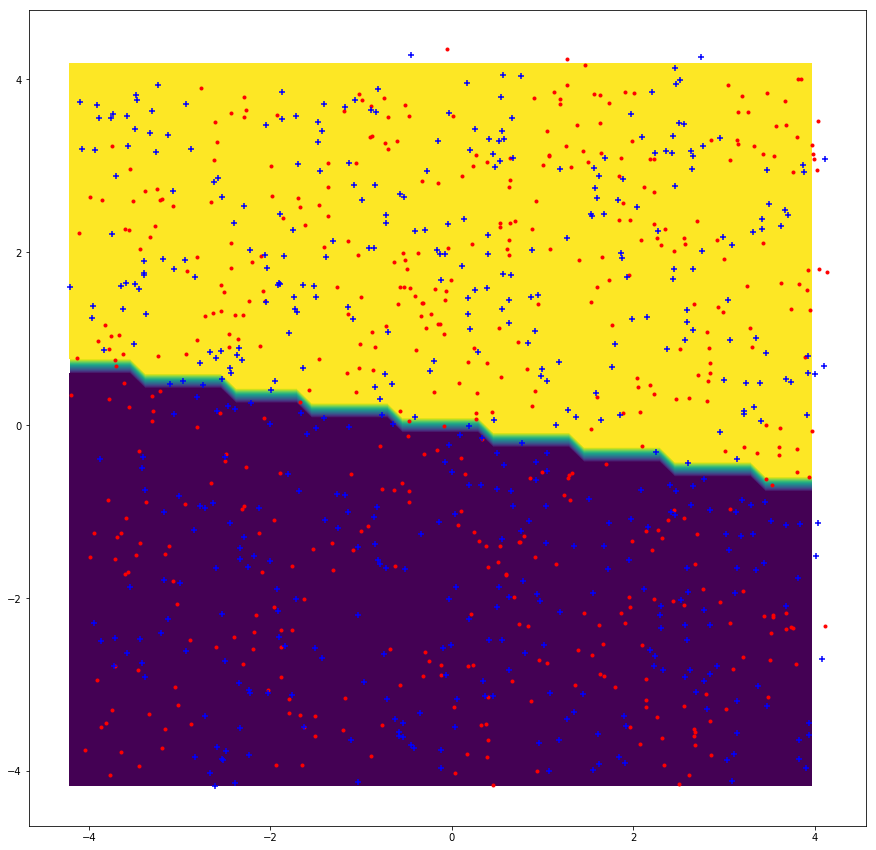

In [13]:
### Generation de donnees

xtrain, ytrain = gen_arti(data_type=1, epsilon=0.2)
xtest, ytest = gen_arti(data_type=1, epsilon=0.2)

### Apprentissage
model = Perceptron(eps=1e-2)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

### Generation de donnees

xtrain, ytrain = gen_arti(data_type=2, epsilon=0.2)
xtest, ytest = gen_arti(data_type=2, epsilon=0.2)

### Apprentissage
model = Perceptron(eps=1e-2)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

Le modèle ne peux pas séparer les données non-linéairement séparables. Cela est normal car il s'agit d'un modèle linéaire.

### Question 3.2 :

Dans l'espace de dimension 6, la frontière de décision sera un hyperplan de dimension 5.

In [14]:
def poly(x):
    """"""
    return np.array([np.ones(x.shape[0]), x[:, 0], x[:, 1], x[:, 0] * x[:, 1], x[:, 0] ** 2, x[:, 1] ** 2]).T

0 [ 0.0013497]
20 [  7.86458490e-05]
40 [  6.37520250e-05]
60 [  6.65205774e-05]
80 [  8.35352068e-05]
score en train :  0.998
score en test :  0.991


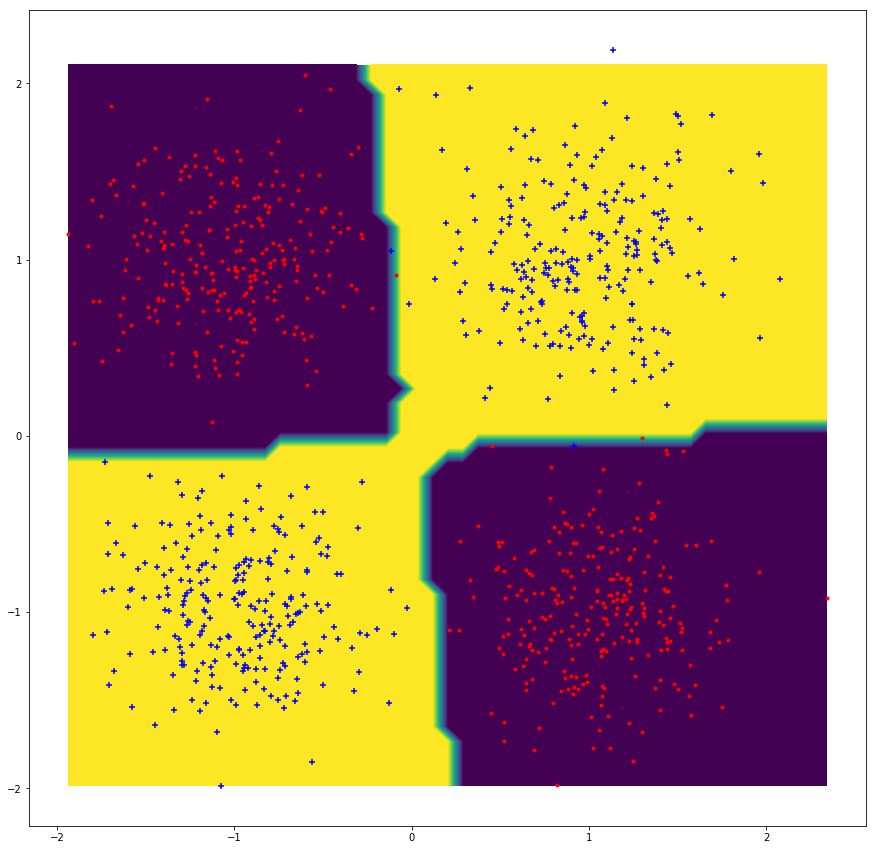

In [15]:
### Generation de donnees

xtrain, ytrain = gen_arti(data_type=1, epsilon=0.2)
xtest, ytest = gen_arti(data_type=1, epsilon=0.2)

### Apprentissage
model = Perceptron(eps=1e-2, projection=poly)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

### Question 3.3 :

Si $o^i$ est le $i^ème$ point choisit de l'espace, 

In [16]:
def k(x, x_p, sigma):
    """"""
    
    return np.exp(- np.linalg.norm(x - x_p, axis=0) / 2 / sigma**2)

def kernel(x, o, n_dim=6, sigma=0.5):
    """"""
    n_ex, n_dim_in  = x.shape
    
    x_proj = np.zeros((n_ex, n_dim))

    for dim in range(n_dim):
        for example in range(n_ex):
            x_proj[example, dim] = k(x[example, :], o[dim, :], sigma)
    
    return x_proj

0 [ 0.00681285]
20 [  7.70925075e-05]
40 [  9.14501902e-05]
60 [  9.77628770e-05]
80 [ 0.00010411]
score en train :  0.993
score en test :  0.995


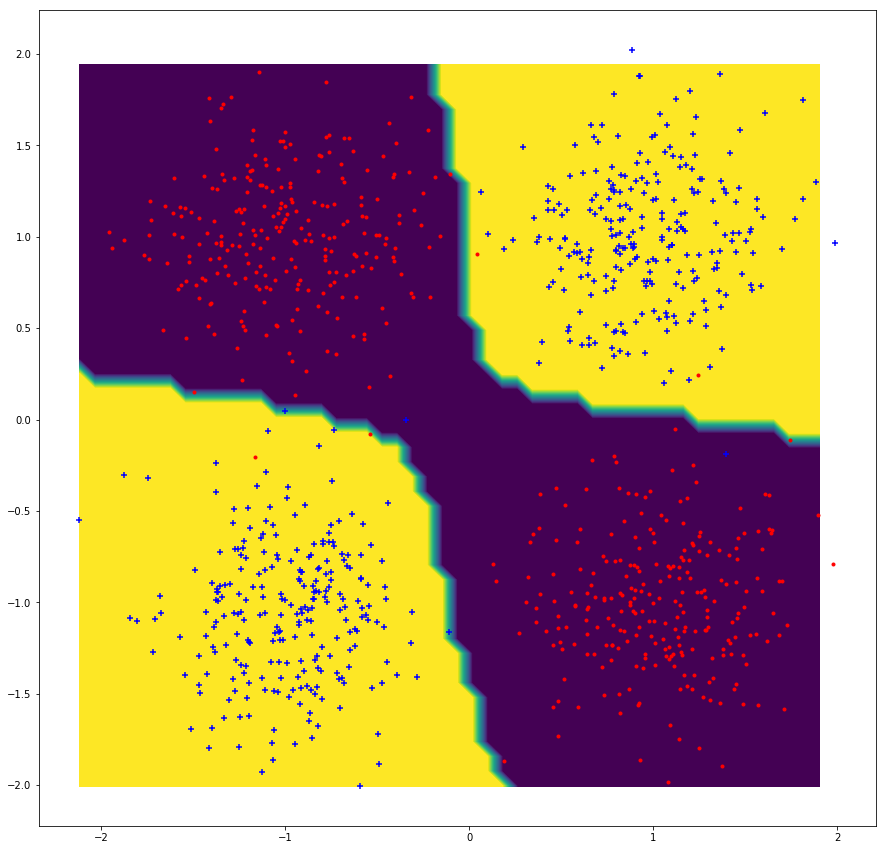

In [17]:
# ### Generation de donnees

xtrain, ytrain = gen_arti(data_type=1, epsilon=0.2)
xtest, ytest = gen_arti(data_type=1, epsilon=0.2)

n_dim = 20
gen="autre"

n_ex, n_dim_in  = xtrain.shape

if gen == "rand":
    o = np.random.rand(n_dim, n_dim_in)
    projec = lambda x : kernel(x, type="rand", n_dim=20)
else :
    index = np.random.randint(n_ex, size=n_dim)
    o = xtrain[index, :]
    projec = lambda x : kernel(x, o, n_dim=n_dim, sigma=3)
    

### Apprentissage
model = Perceptron(eps=1e-2, projection=projec)
model.fit(xtrain, ytrain)
print("score en train : ", model.score(xtrain, ytrain))
print("score en test : ", model.score(xtest, ytest))

#### Tracer de frontiere
plt.figure(num=None, figsize=(15, 15))
plot_frontiere(xtrain, model.predict, 50)
plot_data(xtrain, ytrain)
plt.show()

# À QUOI CORRESPOND LA IEME DIMENSION DANS L'ESPACE PROJETÉ ?
# QUE SIGNIFIE UNE VALEUR FAIBLE OU FORTE ?
# À QUOI CORRESPONDENT LES POIDS WI ?
# qUELLE EST LA SIGNIFICATION D'UN POIDS NUL ? D'UN POIDS POSITIF ÉLEVÉ ?

### Question 3.4

# EXPRESSIVITÉ DU MODÈLE
# ÉVOLUTION EN FONCTION DU NOMBRE DE DIMENSIONS NULLES DE W

In [20]:
class Perceptron_reg:
    def __init__(self, max_iter=100, eps=1e-3, lmb=0.1, projection=None):
        self.max_iter = max_iter
        self.eps = eps
        self.lmb = lmb
        self.projection = projection or (lambda x: x)  # projection fonction identite par default

    def fit(self, data, y):
        data = self.projection(data)
        self.w = np.random.random((1, data.shape[1]))
        self.histo_w = np.zeros((self.max_iter, data.shape[1]))
        self.histo_f = np.zeros((self.max_iter, 1))
        ylab = set(y.flat)
        if len(ylab) != 2:
            print("pas bon nombres de labels (%d)" % (ylab,))
            return
        self.labels = {-1: min(ylab), 1: max(ylab)}
        y = 2 * (y != self.labels[-1]) - 1
        i = 0
        while i < self.max_iter:
            idx = range(len(data))
            for j in idx:
                self.w = self.w - self.get_eps() * self.loss_g(data[j], y[j:(j + 1)])
            self.histo_w[i] = self.w
            self.histo_f[i] = self.loss(data, y)
            if i % 20 == 0: print(i, self.histo_f[i])
            i += 1

    def predict(self, data):
        data = self.projection(data)
        return np.array([self.labels[x] for x in np.sign(data.dot(self.w.T)).flat]).reshape((len(data),))

    def score(self, data, y):
        return np.mean(self.predict(data) == y)

    def get_eps(self):
        return self.eps

    def loss(self, data, y):
        return hinge(self.w, data, y) + self.lmb*np.linalg.norm(self.w)**2

    def loss_g(self, data, y):
        return grad_hinge(self.w, data, y)

-Terme de régularisation -> éviter le sur-apprentissage